In [10]:
using Zygote, Flux, Statistics, Plots, Distributions, LinearAlgebra, ProgressBars, IJulia
using Flux.Optimise: update!

num_particles = 2
harmonic_omega = 1.0
omega = 1
g = 0
sigma = -g/2
C = 2

# make the model
model = f64(Chain(
	Dense(num_particles => 50, bias=true, celu; init=Flux.glorot_normal()),
	Dense(50 => 1, bias=true; init=Flux.glorot_normal())
))

paramCount = 0
for layer in model
    paramCount += sum(length, Flux.params(layer))
end
println("Number of parameters: ", paramCount)

transform(coord) = [sum(coord ./ C).^(i+1) for i in eachindex(coord)] 

nn(coords) = model(transform(coords))[1]
A(coords) = nn(coords) + omega * sum(coords.^2)
psi(coords) = exp(-A(coords))
psi_sq(coords) = psi(coords).^2

# derivative of A wrt the coordinates
dA_dx(coords) = gradient(A,coords)[1]

# take the gradient of A wrt the parameters of the network, which are not passed in as arguments, but are global
function dA_dtheta(coords)
	return gradient(Flux.params(model)) do
		A(coords)
	end
end

# second derivative of A wrt the coordinates
d2A_dx2(coords) = diaghessian(A, coords)[1]

function sample(distribution,  num_particles, num_samples, num_thermalization, num_skip, variation)
    # start by computing the total number of steps that we will take
    total_steps = num_samples * num_skip + num_thermalization
    # number of accepted steps
    num_accepted = 0
    # create a vector of outputs of length num_samples
	samples = Array{Float64}(undef, 0, num_particles)

    # pick a starting point
    x = zeros(num_particles) 
    for step in 1:total_steps 
        # propose a new point
        rand_shift = rand(Uniform(-variation, variation), num_particles)

		x_prime = x + rand_shift
        # generate a random number between 0 and 1
		r = rand(Uniform(0,1))
        if r < distribution(x_prime)/distribution(x)
            # accept the new point
            x = x_prime
            num_accepted += 1
        end

        # now check whether it is time to record a sample
        if step > num_thermalization && mod(step, num_skip) == 0
            # record the sample
            samples = [samples; x']
        end
    end

    # for every sample in samples, replace the second value with a copy of the first value
    samples_prime = copy(samples)
    for i in 1:num_samples
        samples_prime[i, 2] = samples[i, 1]
    end

    return samples, samples_prime, (num_accepted/total_steps) 
end

# define the energy computation
function Hpsi(coords, coords_prime, alpha)
    return Hpwd(coords)  .+ delta_pot(coords, coords_prime, alpha) 
end

function sigma_term(coords)
    sigma_term = 0
    for i in 1:num_particles
        for j in i:num_particles
            sigma_term += sigma * abs(coords[i]-coords[j])
        end
    end
    return sigma_term
end

function Hpwd(coords)
    return 1/2 .* (sum(d2A_dx2(coords)) .- sum(dA_dx(coords).^2)) + 1/2 .* harmonic_omega^2 .* sum(coords.^2) .+ sigma_term(coords)
end

function delta_pot(coords, coords_prime, alpha)
    ratio = psi_sq(coords_prime)/psi_sq(coords)
    delta_dist = (1/(sqrt(pi) * alpha)) * exp(-(coords[1]^2)/(alpha^2))
    return g * num_particles*(num_particles-1)/2 * ratio * delta_dist
end


function second_term(coords)
    return dA_dtheta(coords) .* Hpwd(coords)
end

function third_term(coords, coords_prime, alpha)
    return dA_dtheta(coords_prime) .* delta_pot(coords, coords_prime, alpha)
end

function gradsum(grads)
    sum = grads[1]
    for g in grads[2:end]
        sum = sum .+ g
    end
    return sum
end

function gradmult(grads, scalar)
    for g in grads[1:end]
        if g !== nothing
            g = g .* scalar
        end
    end
end

function grad(num_samples=10^3, thermal=1000, skip=200, variation=1.0)
    # get the samples
    samples, samples_prime, _ = sample(psi_sq, num_particles, num_samples, thermal, skip, variation)

    # get the maximum of the x coordinate in the samples
    y_max = maximum(abs.(samples[:, 2]))
    alpha = y_max/(sqrt(-log(sqrt(pi) * 10^(-10))))

    Es = []
    dadthetas = []
    seconds = []
    thirds = []
    # now iterate through the samples
    for i in 1:num_samples
        # get the current sample
        coords = samples[i, :]
        coords_prime = samples_prime[i, :]
        
        # append Hpsi to Es
        push!(Es, Hpsi(coords, coords_prime, alpha))
        push!(dadthetas, dA_dtheta(coords))
        push!(seconds, second_term(coords))
        push!(thirds, third_term(coords, coords_prime, alpha))
    end
    # compute the average of Es
    E_avg = 1/num_samples * sum(Es)
    dadtheta_avg = 1/num_samples .* gradsum(dadthetas)
    seconds_avg = 1/num_samples .* gradsum(seconds)
    thirds_avg = 1/num_samples .* gradsum(thirds)
    uncert = std(Es)/sqrt(num_samples)
    println(E_avg)
    println(seconds_avg[Flux.params(model)[3]])
    println(thirds_avg[Flux.params(model)[3]])
    g = 2 * E_avg .* dadtheta_avg .- 2 .* seconds_avg  .- 2 .* thirds_avg
    return g, E_avg, uncert
end

function train(initial_params, iterations, num_samples, learning_rate, variation)
    opt = ADAM(learning_rate)  # Ensure to set the learning rate
    # set the model parameters 
    Flux.loadparams!(model, initial_params)
    # arrays to store the energies and uncertainties
    energies = []
    uncerts = []

    # now train
    iter =  ProgressBars.tqdm(1:iterations) 
    for step in iter
        # compute the gradient 
        g, energy, uncert =  grad(num_samples, 1000, 200, variation)
        # append the energy and uncert
        push!(energies, energy)
        push!(uncerts, uncert)
        set_description(iter , string(energy))
        # update the parameters
        for p in Flux.params(model)
            Flux.update!(opt, p, g[p])  # Update parameters in place
        end
        IJulia.clear_output(true)
    end
    return energies, uncerts
end


Number of parameters: 201


train (generic function with 1 method)

In [7]:
println(psi([1,2]))
println(dA_dx([1,2]))
println(d2A_dx2([1,2]))
println(Hpwd([1,2]))

0.007124355600542821
[2.0699303587500073, 4.069930358750007]
[2.0355859778959693, 2.0355859778959693]
-5.888886429678976


0.4837910447761194


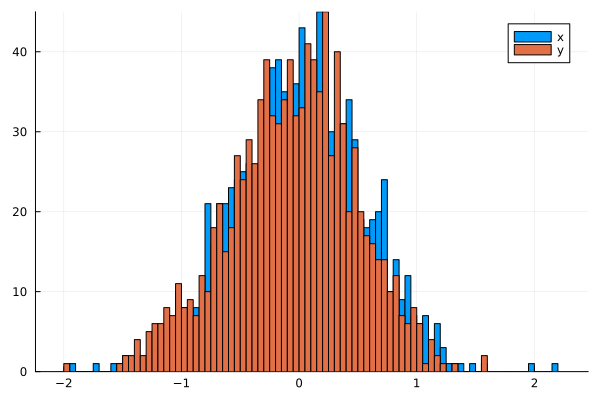

In [8]:
# get samples and print the acceptance rate
samples, samples_prime, rate = sample(psi_sq, num_particles, 10^3, 1000, 200, 1)
println(rate)
# get all the x values
xs = samples[:, 1]
# get all the y values
ys = samples[:, 2]
# histogram the x samples
histogram(xs, bins=100, label="x")
# histogram the y samples
histogram!(ys, bins=100, label="y")


In [11]:
res = train(Flux.params(model), 30, 10^3, 10^(-3), 1)

1.1334884290697107 100.0%┣██████████████████████████┫ 30/30 [01:01<00:00, 2s/it]
1.1334884290697107 100.0%┣██████████████████████████┫ 30/30 [01:01<00:00, 2s/it]


(Any[1.2091954211868903, 1.223861313458073, 1.2142598489000602, 1.1926544187098467, 1.2188863583094787, 1.1711456381719143, 1.216278744702235, 1.2262974411998622, 1.245464005516316, 1.1895716528179656  …  1.1987968170597831, 1.1697422424736201, 1.213675687581703, 1.1448547344264004, 1.1452330563917725, 1.16499476852941, 1.192337575639099, 1.185766524163179, 1.1320811975603797, 1.1334884290697107], Any[0.02234815101718937, 0.021679318416406263, 0.021348378382090843, 0.022075925839748742, 0.02115992732993297, 0.023056292335758986, 0.021109084290269333, 0.021070158091450523, 0.020323402603489922, 0.021120892438997296  …  0.016997476290763217, 0.020081770553980225, 0.018757687509832515, 0.019981223432209313, 0.02003985260820074, 0.0195725701965329, 0.01739006998908493, 0.018378516031531577, 0.020202674089327854, 0.019647732754032945])

In [ ]:
samples, samples_prime, rate = sample(psi_sq, num_particles, 10^3, 1000, 200, 1)
println(rate)

In [ ]:
res2 = train(Flux.params(model), 50, 10^3, 10^(-4), 1)

In [ ]:
samples, samples_prime, rate = sample(psi_sq, num_particles, 10^3, 1000, 200, 1)
println(rate)

In [ ]:
println(Flux.params(model))

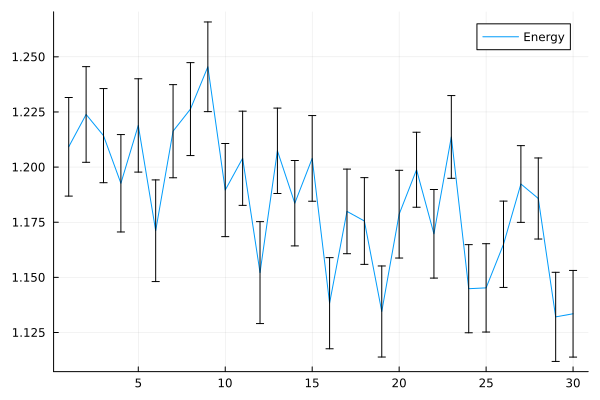

In [14]:
# append the energies and uncerts
# energies = vcat(res[1],res2[1])
# uncerts = vcat(res[2],res2[2])
energies = res[1]
uncerts = res[2]


plot(energies, yerr=uncerts, label="Energy")